In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#%load_ext memory_profiler
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
import scipy.ndimage
#POPPY
import poppy
from poppy.poppy_core import PlaneType
print("POPPY Version: "+poppy.__version__)
#silence DEBUG and WARNINGs
import logging
logging.getLogger('poppy').setLevel(logging.ERROR)
# MagAO-X function definitions
from model_kit import magaoxFunctions as mf
from model_kit import datafiles as dfx
# draw the dark hole regions
from skimage.draw import draw
# for writing files
from datetime import date
print('Last date this notebook was ran: {0}'.format(date.today()))
import copy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

def rms(data):
    return np.sqrt(np.sum(np.square(data))/len(data))

POPPY Version: 0.9.2.dev11+g1887dd5
Last date this notebook was ran: 2021-11-10


In [15]:
# initial conditions
fr_parm = {'wavelength': 656e-9 * u.m,
           'npix': 538, # sample size
           'beam_ratio': 0.25, # oversample
           'leak_mult': 0.01,
           'n_tests': 10,
           'n_loop': 4,
           'set': 0,
           'bump': True,
           'wfe_data': 'allopd'} # other: 'allopd', 'common'

# set up prescription details
wavelen_str = str(np.round(fr_parm['wavelength'].to(u.nm).value).astype(int))
br = int(1/fr_parm['beam_ratio'])
parm_name = '{0:3}_{1:1}x_{2}nm'.format(fr_parm['npix'], br, wavelen_str)

# set up file locations
home_dir = '/home/jhen/XWCL/code/MagAOX/' # change for exao0
data_dir = home_dir + 'data/'
fr_out_dir = 'data_fig/n0_allopd/'

# tweeter mask
tw_mask = fits.open(data_dir+'mask/lyot_tweeter_amp_mask_bump_538.fits')[0].data

In [20]:
# pull out the data

# initial state
dm_open = fits.open(data_dir+'wfemap/tweeter_meters_opd_538.fits')[0].data*1e9 # convert to nm
wfs_open = fits.open(fr_out_dir+'wf_s2_i0_phase.fits')[0].data

# 4th loop state
dm_closed = fits.open(fr_out_dir+'dm_opd_s2_i4.fits')[0].data*1e9 # convert to nm
wfs_closed = fits.open(fr_out_dir+'wf_s2_i4_phase.fits')[0].data

# Plotting math
# for colorbar purposes
dm_low = np.amin((dm_open, dm_closed))
dm_high = np.amax((dm_open, dm_closed))
ph_low = np.amin((wfs_open, wfs_closed))
ph_high = np.amax((wfs_open, wfs_closed))

# set the scaling range for the wavefront axis
box = int(fr_parm['npix']/2) # Half the size of the window region of interest
rk = np.linspace(-box, box, (box*2), endpoint=False) * u.pix

# for the wfs
wfs_pixscale = fits.open(fr_out_dir+'wf_s0_i4_phase.fits')[0].header['pixelscl']*u.m/u.pix
rk_wfs = ((rk * wfs_pixscale).to(u.mm)).value
# for the tweeter
tw_pixscale = fits.open(fr_out_dir+'dm_opd_s0_i4.fits')[0].header['puplscal']*u.m/u.pix
rk_tw = ((rk * tw_pixscale).to(u.mm)).value

# put the white background
dm_open = dfx.sn_map(dm_open, tw_mask)
wfs_open = dfx.sn_map(wfs_open, tw_mask)
dm_closed = dfx.sn_map(dm_closed, tw_mask)
wfs_closed = dfx.sn_map(wfs_closed, tw_mask)

# calculate the rms to add to plots
dm_open_rms = rms(dm_open[tw_mask==1])
dm_closed_rms = rms(dm_closed[tw_mask==1])
wfs_open_rms = rms(wfs_open[tw_mask==1])
wfs_closed_rms = rms(wfs_closed[tw_mask==1])

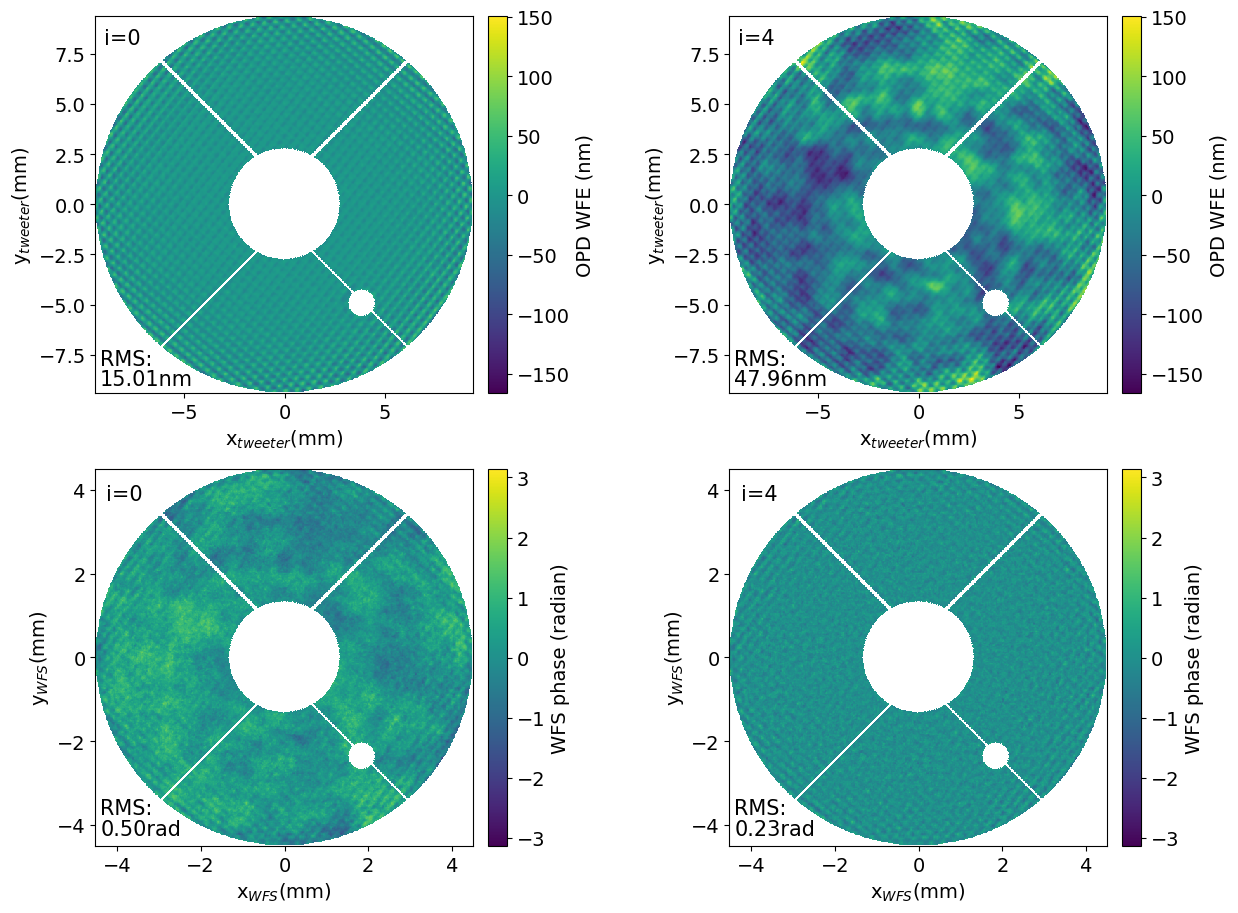

In [39]:
# plot plot plot
matplotlib.rcParams["font.size"]=14
fig, (axs) = plt.subplots(nrows=2, ncols=2, figsize=(15,11), dpi=100,
                         facecolor='white')

# top row: DM plots
r0c0 = axs[0,0].imshow(dm_open, origin='lower',
                       extent=[np.amin(rk_tw), np.amax(rk_tw), np.amin(rk_tw), np.amax(rk_tw)],
                       vmin=dm_low, vmax=dm_high)
axs[0,0].set_ylabel(r'y$_{tweeter}$(mm)')
axs[0,0].set_xlabel(r'x$_{tweeter}$(mm)')
axs[0,0].text(-9,8, 'i=0', fontsize=15)
axs[0,0].text(-9.2,-8, 'RMS:', fontsize=15)
axs[0,0].text(-9.2,-9, '{0:.2f}nm'.format(dm_open_rms), fontsize=15)
divider = make_axes_locatable(axs[0,0])
cax1 = divider.append_axes("right", size="5%", pad=0.15)
fig.colorbar(r0c0, cax=cax1).set_label('OPD WFE (nm)')
#fig.colorbar(r0c0, ax=axs[0,0]).set_label('nm')

r0c1 = axs[0,1].imshow(dm_closed, origin='lower',
                       extent=[np.amin(rk_tw), np.amax(rk_tw), np.amin(rk_tw), np.amax(rk_tw)],
                       vmin=dm_low, vmax=dm_high)
axs[0,1].set_ylabel(r'y$_{tweeter}$(mm)')
axs[0,1].set_xlabel(r'x$_{tweeter}$(mm)')
axs[0,1].text(-9,8, 'i=4', fontsize=15)
axs[0,1].text(-9.2,-8, 'RMS:', fontsize=15)
axs[0,1].text(-9.2,-9, '{0:.2f}nm'.format(dm_closed_rms), fontsize=15)
divider = make_axes_locatable(axs[0,1])
cax2 = divider.append_axes("right", size="5%", pad=0.15)
fig.colorbar(r0c1, cax=cax2).set_label('OPD WFE (nm)')
#fig.colorbar(r1c0, ax=axs[1,0]).set_label('nm')

# bottom row: WFS data
r1c0 = axs[1,0].imshow(wfs_open, origin='lower',
                       extent=[np.amin(rk_wfs), np.amax(rk_wfs), np.amin(rk_wfs), np.amax(rk_wfs)],
                       vmin=ph_low, vmax=ph_high)
axs[1,0].set_ylabel(r'y$_{WFS}$(mm)')
axs[1,0].set_xlabel(r'x$_{WFS}$(mm)')
axs[1,0].text(-4.25,3.75, 'i=0', fontsize=15)
axs[1,0].text(-4.4,-3.75, 'RMS:', fontsize=15)
axs[1,0].text(-4.4,-4.25, '{0:.2f}rad'.format(wfs_open_rms), fontsize=15)
divider = make_axes_locatable(axs[1,0])
cax3 = divider.append_axes("right", size="5%", pad=0.15)
fig.colorbar(r1c0, cax=cax3).set_label('WFS phase (radian)')
#fig.colorbar(r0c1, ax=axs[0,1]).set_label('radian')

r1c1 = axs[1,1].imshow(wfs_closed, origin='lower',
                       extent=[np.amin(rk_wfs), np.amax(rk_wfs), np.amin(rk_wfs), np.amax(rk_wfs)],
                       vmin=ph_low, vmax=ph_high)
axs[1,1].set_ylabel(r'y$_{WFS}$(mm)')
axs[1,1].set_xlabel(r'x$_{WFS}$(mm)')
axs[1,1].text(-4.25,3.75, 'i=4', fontsize=15)
axs[1,1].text(-4.4,-3.75, 'RMS:', fontsize=15)
axs[1,1].text(-4.4,-4.25, '{0:.2f}rad'.format(wfs_closed_rms), fontsize=15)
divider = make_axes_locatable(axs[1,1])
cax4 = divider.append_axes("right", size="5%", pad=0.15)
fig.colorbar(r1c1, cax=cax4).set_label('WFS phase (radian)')
#fig.colorbar(r1c1, ax=axs[1,1]).set_label('radian')